In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

import utils
from pre_process import preprocess_mask

Segmentation Models: using `keras` framework.


In [2]:
from sklearn.model_selection import train_test_split
import data_loader

# load INRIA dataset with different locations
# austin, chicago, kitsap, tyrol-w, vienna
locations = ['austin']

base_dir = os.getcwd()
image_dir = os.path.join(base_dir, 'data_INRIA/train/images/')
mask_dir = os.path.join(base_dir, 'data_INRIA/train/gt/')


load_X, load_y = data_loader.load_INRIA(
    image_dir,
    mask_dir,
    locations,
    type = 'train',
    img_size=384)

load_Xtest, load_ytest = data_loader.load_INRIA(
    image_dir,
    mask_dir,
    locations,
    type = 'test',
    img_size=384)

# get a small amount of data for the pretrained model
count = []
for i in range(len(load_y)):
    if (np.sum(load_y[i]) < 384*384*250*0.01):
        count.append(i)
print(len(count))

load_X = np.delete(load_X, count, 0)
load_y = np.delete(load_y, count, 0)

image_dataset = np.array(load_X)
mask_dataset =  np.array(load_y)

image_test = np.array(load_Xtest)
mask_test =  np.array(load_ytest)

print(image_dataset.shape, mask_dataset.shape)
print(image_test.shape, mask_test.shape)


image size: (6076, 384, 384, 3)
mask size: (6076, 384, 384, 3)
image size: (980, 384, 384, 3)
mask size: (980, 384, 384, 3)
933
(5143, 384, 384, 3) (5143, 384, 384, 3)
(980, 384, 384, 3) (980, 384, 384, 3)


In [3]:
label_train = preprocess_mask(mask_dataset, 15)

Unique values in mask dataset are:  [  0. 120. 255.]
Unique labels in label dataset are:  [0 1 2]


In [4]:
label_test = preprocess_mask(mask_test, 15)

Unique values in mask dataset are:  [  0. 120. 255.]
Unique labels in label dataset are:  [0 1 2]


In [5]:
n_classes = len(np.unique(label_train))

from tensorflow.keras.utils import to_categorical
label_train_tocat = to_categorical(label_train, num_classes=n_classes)
label_test_tocat = to_categorical(label_test, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_dataset, label_train_tocat, test_size = 0.20, random_state = 42)

X_test, y_test = image_test, label_test_tocat

# Model path

In [6]:
# the path that we want to save the model
base_dir = os.getcwd()
model_name = 'models/bench_ep100_bd15_aus99.h5'
model_path = os.path.join(base_dir, model_name)


# Model


In [7]:
import tensorflow as tf
from unet_model import jacard_coef  

metrics=['accuracy', jacard_coef]

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_jacard_coef', 
    mode='max', 
    verbose=1, 
    patience=10)

mc = tf.keras.callbacks.ModelCheckpoint(
    model_path, 
    monitor='val_jacard_coef', 
    mode='max', 
    verbose=1, 
    save_best_only=True)
    

In [8]:
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
sm.set_framework('tf.keras')
sm.framework()

#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)

# define model
# model_resnet_backbone = sm.Unet(BACKBONE, input_shape=(None, None, 3), encoder_weights='imagenet', classes=n_classes, activation='softmax')
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')


# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [9]:
history2 = model_resnet_backbone.fit(
    X_train_prepr, 
    y_train,
    batch_size=8,
    epochs=100,
    verbose=1,
    validation_data=(X_val_prepr, y_val),
    callbacks=[es, mc])

Epoch 1/100
515/515 [==============================] - 229s 402ms/step - loss: 0.4130 - accuracy: 0.8462 - jacard_coef: 0.6117 - val_loss: 0.2871 - val_accuracy: 0.8957 - val_jacard_coef: 0.7321

Epoch 00001: val_jacard_coef improved from -inf to 0.73207, saving model to c:\Users\edton\Desktop\Work\5.UCL\ML Masters (21-22)\T0_Masters project\models and datasets\INRIA_files\models\bench_ep100_bd15_aus99.h5


C:\Users\edton\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
515/515 [==============================] - 200s 389ms/step - loss: 0.2559 - accuracy: 0.9060 - jacard_coef: 0.7482 - val_loss: 0.2505 - val_accuracy: 0.9075 - val_jacard_coef: 0.7592

Epoch 00002: val_jacard_coef improved from 0.73207 to 0.75917, saving model to c:\Users\edton\Desktop\Work\5.UCL\ML Masters (21-22)\T0_Masters project\models and datasets\INRIA_files\models\bench_ep100_bd15_aus99.h5
Epoch 3/100
515/515 [==============================] - 201s 390ms/step - loss: 0.2185 - accuracy: 0.9185 - jacard_coef: 0.7825 - val_loss: 0.2251 - val_accuracy: 0.9168 - val_jacard_coef: 0.7803

Epoch 00003: val_jacard_coef improved from 0.75917 to 0.78031, saving model to c:\Users\edton\Desktop\Work\5.UCL\ML Masters (21-22)\T0_Masters project\models and datasets\INRIA_files\models\bench_ep100_bd15_aus99.h5
Epoch 4/100
515/515 [==============================] - 201s 390ms/step - loss: 0.1923 - accuracy: 0.9272 - jacard_coef: 0.8054 - val_loss: 0.2296 - val_accuracy: 0.9141 - val_j

models/bench_ep100_bd15_aus99.h5


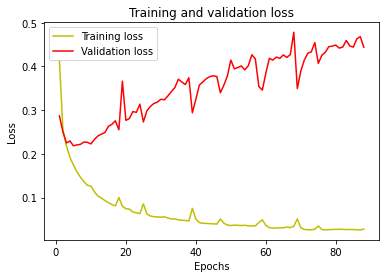

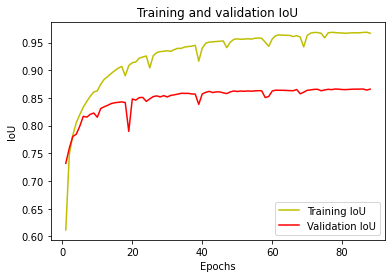

In [10]:
#plot the training and validation accuracy and loss at each epoch
print(model_name)

history = history2
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

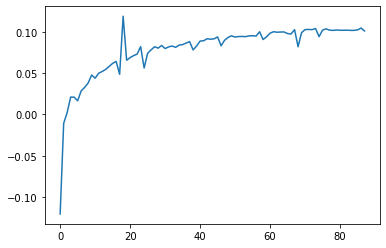

In [11]:
plt.plot(np.array(acc) - np.array(val_acc))

# Prediction

In [12]:
import utils
# predicting by batches to prevent going out of resource
y_pred = utils.batch_predict(X_test, model_resnet_backbone, 300, labels=n_classes)
# y_pred=model.predict(X_eval)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

Data size:  980


Predicting batches...: 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]


1


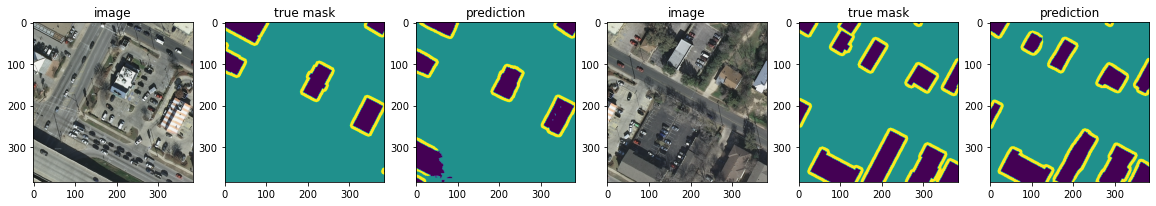

3


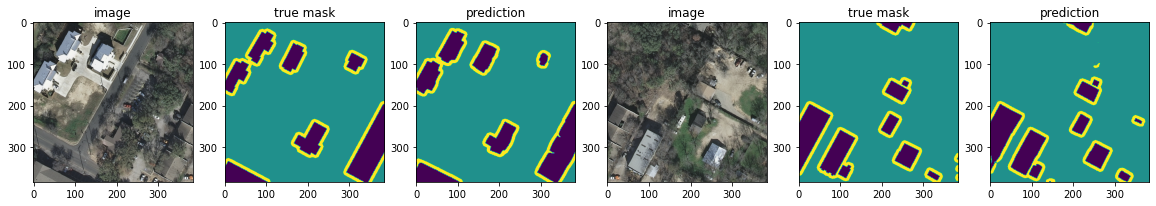

5


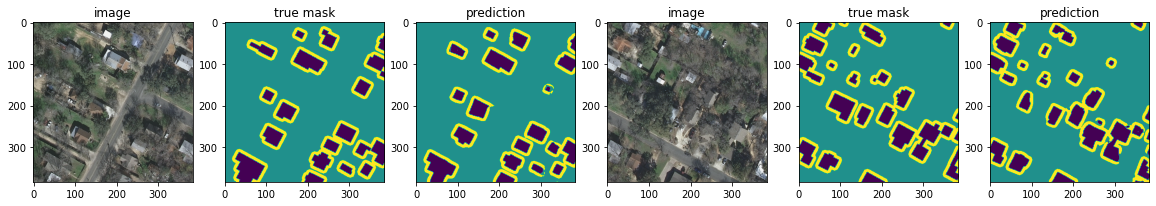

7


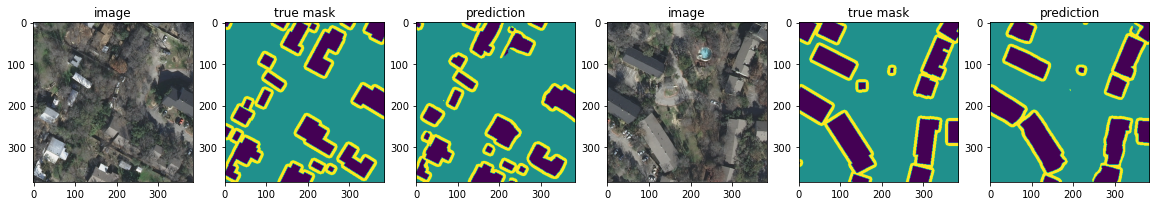

9


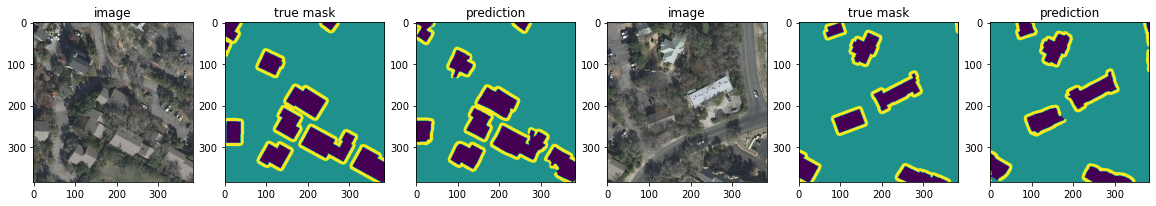

11


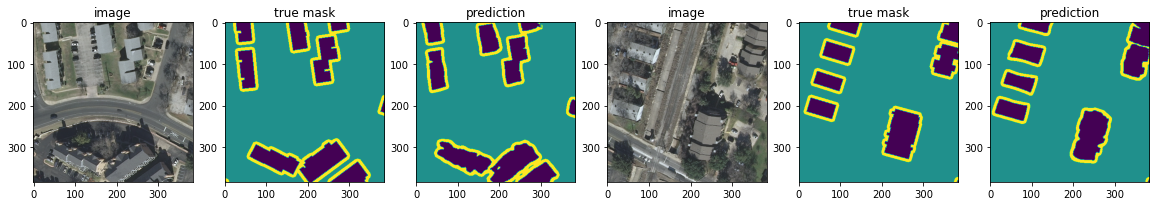

13


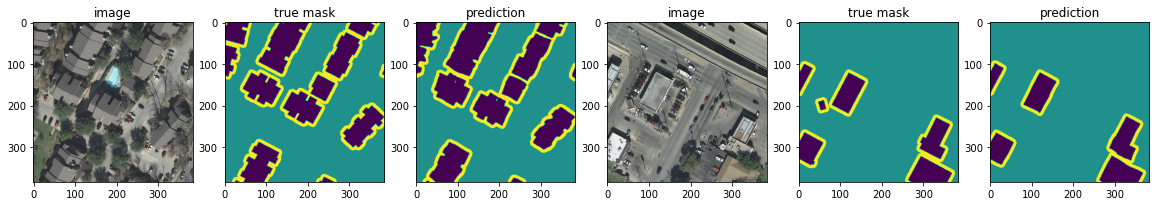

15


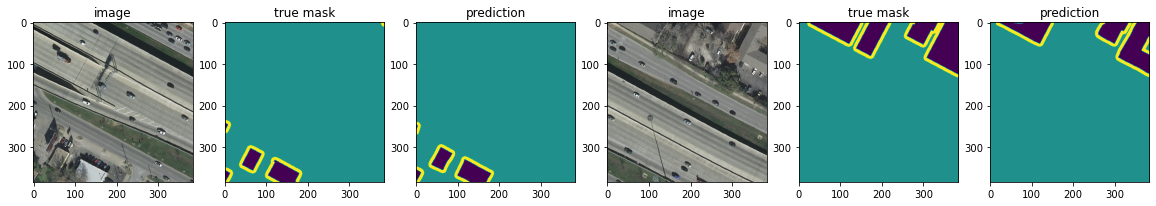

17


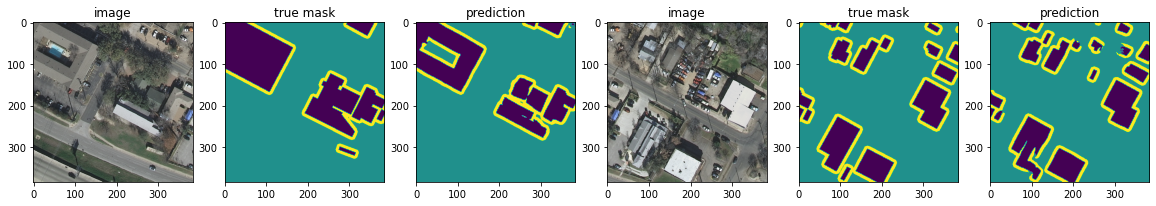

19


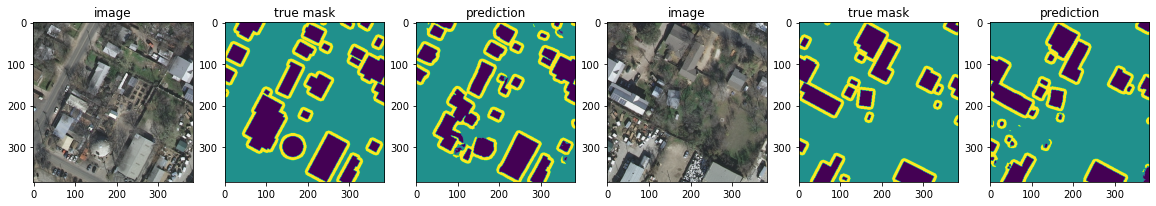

21


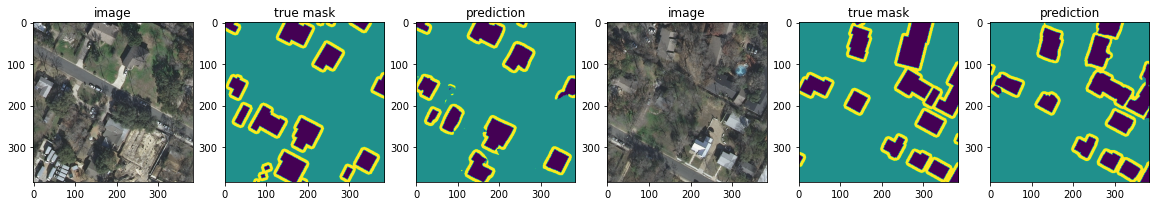

23


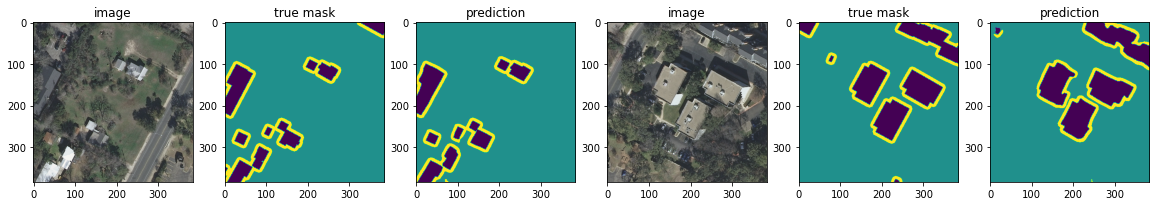

25


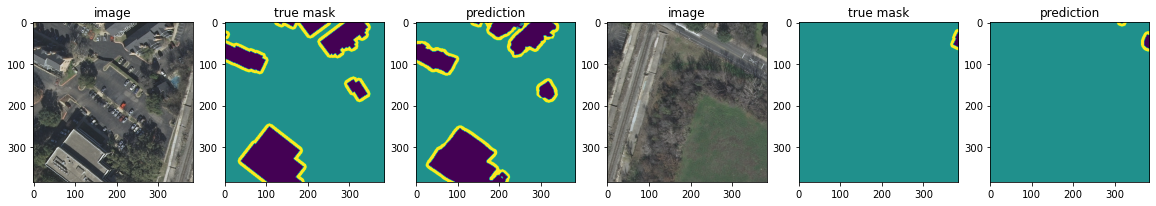

27


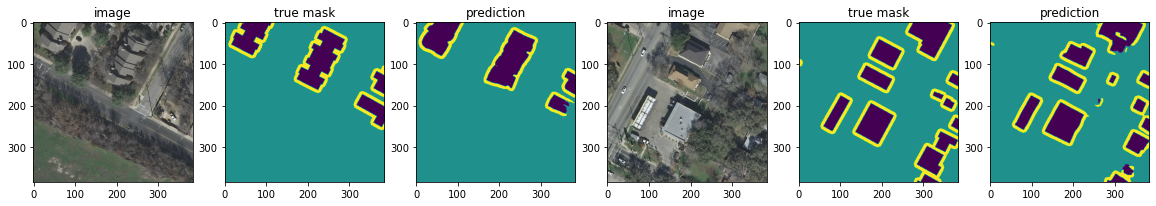

29


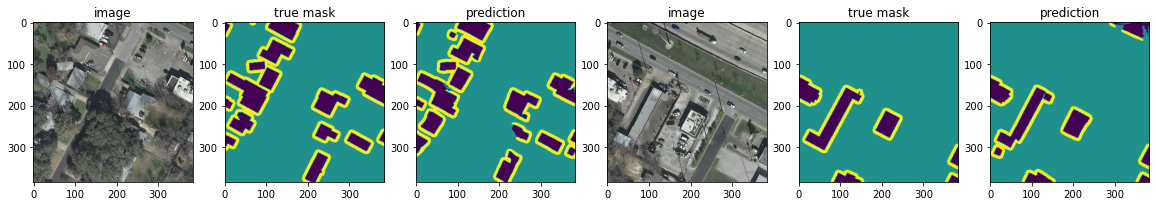

In [13]:
utils.plot6images(
    [X_test, 'image'], 
    [y_test_argmax, 'true mask'], 
    [y_pred_argmax, 'prediction'], 
    [X_test[1:], 'image'], 
    [y_test_argmax[1:], 'true mask'], 
    [y_pred_argmax[1:], 'prediction'], 
    # idx_list = [10, 30, 60, 120, 200, 250, 159, 1471, 1627, 1819]) 
    # idx_list = np.random.randint(0, len(y_test_argmax), 10)) 
    idx_list = np.arange(1,30, 2)) 

In [14]:
utils.classwiseIoU(y_pred_argmax, y_test_argmax, model_name)
print(y_pred_argmax.shape, y_test_argmax.shape)

The classwise IOU: [0.7871 0.946  0.5474]
The average IOU: 0.7601695788590425
---------- Results of models/bench_ep100_bd15_aus99.h5 ----------
(980, 384, 384) (980, 384, 384)


In [17]:
convert_pred = np.where(y_pred_argmax == 0, 0, 1)
convert_true = np.where(y_test_argmax == 0, 0, 1)

In [18]:
utils.classwiseIoU(convert_pred, convert_true, model_name)

The classwise IOU: [0.7871 0.9611]
The average IOU: 0.8740885214957028
---------- Results of models/bench_ep100_bd15_aus99.h5 ----------


In [21]:
correct = np.where(convert_pred == convert_true, 1, 0)
total_pixels = convert_pred.shape[0] * convert_pred.shape[1] * convert_pred.shape[2]
accuracy = np.sum(correct)/total_pixels

print(f'The overall Accuracy: {accuracy}')

The overall Accuracy: 0.965957925325078


# Save some results

In [15]:
# the path that we want to save the model
base_dir = os.getcwd()
result_name = 'result/bench_ep100_bd15_aus99.npy'
result_path = os.path.join(base_dir, result_name)

np.save(result_path, y_pred_argmax[:50])